# Results Overview

### Imports

In [29]:
from catboost import CatBoostClassifier
import polars as pl
import matplotlib.pyplot as plt
import os

### Config

In [30]:
from dotenv import load_dotenv


load_dotenv()

results_dir = os.getenv('RESULTS_DIR', './results')
models_dir = os.getenv('MODELS_DIR', './models')

In [31]:
# Change working directory
os.chdir("/home/mle-user/mle_projects/mle-project-sprint-4")

In [32]:
results_path = os.path.join(results_dir, 'models_comparison.parquet')
model_path = os.path.join(models_dir, 'catboost_classifier.cbm')
plot_path_importance = os.path.join(results_dir, 'feature_importances.png')
parquet_path = os.path.join(results_dir, 'feature_importances.parquet')


### Models comparison

In [33]:
# Check models results
if not os.path.exists(results_path):
    raise FileNotFoundError(f'Model not found at: {results_path}')

models_results = pl.read_parquet(results_path)
display(models_results)

model,k,precision@k,recall@k,ndcg@k,novelty@k,diversity@k
str,str,f64,f64,f64,f64,f64
"""popularity""","""k=5""",0.006427,0.00292,0.006157,0.214157,1.0
"""als""","""k=5""",0.012868,0.011875,0.015725,1.937643,1.0
"""ranked""","""k=5""",0.015809,0.012659,0.018956,1.586918,1.0


Based on the comparison of the three models across metrics precision@k, recall@k, and ndcg@k, the Catboost ranked model demonstrates the best recommendation quality.

CatBoost ranked model has:

- highest precision@5 (0.015809)
  
The model is more accurate in forming the top-5 recommendations. 

- highest recall@5 (0.012659)
  
The ranked model covers more relevant items among those available to the user. 

- highest ndcg@5 (0.018956)
  
The correct items appear higher in the recommendation list.

- lower novelty@5 (1.59) than ALS (1.94) but much higher than popularity (0.21)
  
Ranked model recommends less mainstream items than popularity but slightly less novel items than ALS.

- same diversity@5 (1.0) as others
  
Diversity is identical across models and does not influence model selection.

Thus, Catboost ranked model delivers the highest accuracy and ranking quality while preserving reasonable novelty and maintaining full diversity.

На основе сравнения трех моделей по метрикам precision@k, recall@k и ndcg@k, модель CatBoost ranked демонстрирует наилучшее качество рекомендаций.

Модель CatBoost показывает:

- самый высокий precision@5 (0.015809)
  
Модель точнее формирует топ-5 рекомендаций. 

- самый высокий recall@5 (0.012659)

Mодель охватывает больше релевантных объектов среди доступных пользователю. 

- самый высокий ndcg@5 (0.018956)

Правильные элементы оказываются выше в списке рекомендаций.

- более низкий novelty@5 (1.59), чем у ALS (1.94), но значительно выше, чем у popularity (0.21)
Mодель рекомендует меньше мейнстримовых треков, чем popularity, но чуть менее новые, чем ALS.

- одинаковый diversity@5 (1.0) с другими моделями

Разнообразие одинаково для всех моделей и не влияет на выбор модели.

Таким образом, модель CatBoost ranked обеспечивает наивысшую точность и качество ранжирования, сохраняя при этом разумную новизну и разнообразие.

### CatBoost Feature importances

In [34]:
# Check feature comparison
if not os.path.exists(model_path):
    raise FileNotFoundError(f'Model not found at: {model_path}')

model = CatBoostClassifier()
model.load_model(model_path)

In [35]:
# Extract feature importances
importances = model.get_feature_importance(type="PredictionValuesChange")
feature_names = model.feature_names_

In [36]:
# Create Polars dataframe
catboost_feature_importances = pl.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort("importance", descending=True)

display(catboost_feature_importances)

feature,importance
str,f64
"""artist_popularity""",30.668472
"""popularity_score""",26.850894
"""genre_popularity""",22.356264
"""als_score""",20.022419
"""track_group_size""",0.101951


The model’s ranking decisions are driven mainly by popularity dynamics and collaborative filtering, suggesting that user behavior patterns and global trends carry the strongest predictive power. Structural or catalogue-level features are far less impactful. 

So future improvements of final model quality may come from enriching the model with more detailed user-level behavioral signals, as well as tuning of training hyperparameters.

Решения модели при ранжировании в наибольшей степени определяются динамикой популярности и сигналами коллаборативной фильтрации, что указывает на ведущую роль пользовательских паттернов и глобальных трендов. Структурные или каталоговые признаки оказывают значительно меньшее влияние.

Поэтому дальнейшее улучшение качества итоговой модели может быть достигнуто за счет обогащения ее более детальной поведенческой историей пользователей, а также за счет настройки гиперпараметров обучения модели.

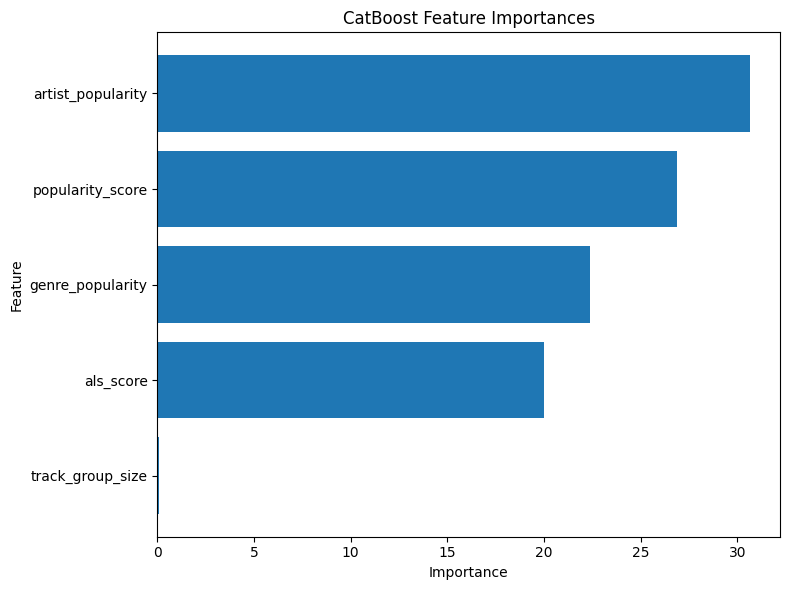

In [37]:
# Plot feature importances
# Convert to Python lists for plotting
feat = catboost_feature_importances['feature'].to_list()
imp = catboost_feature_importances['importance'].to_list()

plt.figure(figsize=(8, 6))
plt.barh(feat, imp)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [38]:
# Save feature importances dataframe and plot
catboost_feature_importances.write_parquet(parquet_path)
plt.savefig(plot_path_importance)

<Figure size 640x480 with 0 Axes>

### Conclusion

The ranked model is the best performer of the considered models.

Music recommendation system may consists of two levels:
- offline recommendations
  
By using CatBoost ranked model at this stage users can receive more relevant tracks on the top of the list. 

- online recommendations

At this stage similarity-based recommendations may be provided so some diversity of recommendations can positively effect users experience. 

Модель CatBoost ranked является лучшей среди рассмотренных.

Система музыкальных рекомендаций может состоять из двух уровней:
- офлайн-рекомендации
  
Использование рекомендаций модели CatBoost на этом этапе позволяет учесть предпочтения пользователя и позво- ляет получать более релевантные треки в верхних позициях списка.

- онлайн-рекомендации
  
На этом этапе могут предоставляться рекомендации на основе сходства треков, поэтому некоторая диверсификация рекомендаций может положительно влиять на пользовательский опыт.